In [245]:
import pulse2percept as p2p
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import cv2

import sys
sys.path.append('../ZoeDepth')
from zoedepth.utils.misc import get_image_from_url, colorize
from PIL import Image

%matplotlib inline

In [246]:
zoe = torch.hub.load("../ZoeDepth", "ZoeD_N", source="local", pretrained=True)

img_size [384, 512]


Using cache found in C:\Users\csirlin/.cache\torch\hub\intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [247]:
# img_url = "http://static1.squarespace.com/static/6213c340453c3f502425776e/62f2452bc121595f4d87c713/62f3c63c5eec2b12a333f851/1661442296756/Screenshot+2022-08-10+at+15.55.27.png?format=1500w" #@param {type:"string"}
# img = get_image_from_url(img_url)
img = Image.open('depth.jpg')
depth = zoe.infer_pil(img)
img = np.array(img)

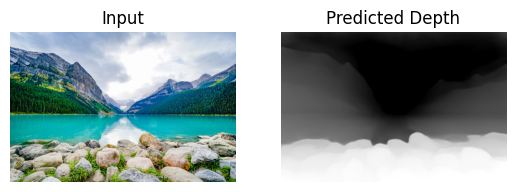

In [248]:
colored_depth = colorize(depth)
fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, colored_depth], ['Input', 'Predicted Depth']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

In [249]:
# print info about the depth image. depth is in meters
print(depth.shape, depth.max(), depth.min(), depth.mean())

(720, 1080) 5.4121437 1.1850127 3.3651345


In [250]:
x_map, y_map = np.meshgrid(np.arange(depth.shape[1]), np.arange(depth.shape[0]))
print(x_map)

[[   0    1    2 ... 1077 1078 1079]
 [   0    1    2 ... 1077 1078 1079]
 [   0    1    2 ... 1077 1078 1079]
 ...
 [   0    1    2 ... 1077 1078 1079]
 [   0    1    2 ... 1077 1078 1079]
 [   0    1    2 ... 1077 1078 1079]]


In [251]:
# compute shifted image
fov = 60
fov_rad = fov * math.pi / 180
x = depth.shape[1] # width in pixels
eye_dist = 0.063 # on average, eyes are 63mm apart
x_displaced = x_map + x*eye_dist/(2*depth*np.tan(fov_rad/2))
x_displaced = np.clip(x_displaced, 0, x-1)
warped_image = cv2.remap(img, x_displaced.astype(np.float32), y_map.astype(np.float32), cv2.INTER_LINEAR)

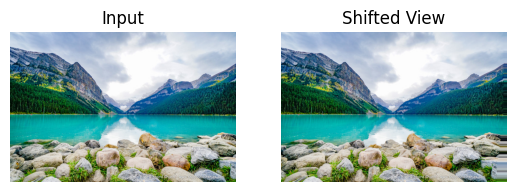

In [252]:
fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, warped_image], ['Input', 'Shifted View']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

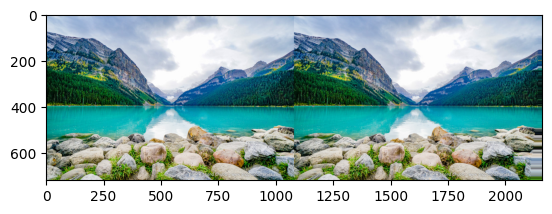

In [253]:
# look closely to get the magic eye/3D effect
img_and_warped = np.hstack((img, warped_image))
plt.imshow(img_and_warped)

In [254]:
### pulse2percept time ###

# start with a really idealistic prosthetic with tons of electrodes
def get_big_prosthesis():
    earray = p2p.implants.ElectrodeArray([])
    e_count = 0
    for i in range(-3000, 3000, 100):
        for j in range(-3000, 3000, 100):
            earray.add_electrode(e_count, p2p.implants.DiskElectrode(i, j, z=0, r=25))
            e_count += 1
    return p2p.implants.ProsthesisSystem(earray)
    
def get_percept_data_from_image(image, model, prosthesis):
    prosthesis.stim = p2p.stimuli.ImageStimulus(image)
    percept = model.predict_percept(prosthesis)
    return percept.data

In [255]:
scoreboard = p2p.models.ScoreboardModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=100)
scoreboard.build()

ScoreboardModel(engine=None, grid_type='rectangular', 
                n_gray=None, n_jobs=1, n_threads=4, 
                ndim=[2], noise=None, rho=100, 
                scheduler='threading', 
                spatial=ScoreboardSpatial, temporal=None, 
                thresh_percept=0, verbose=True, 
                vfmap=Watson2014Map(ndim=2), 
                xrange=(-12, 12), xystep=0.1, 
                yrange=(-12, 12))

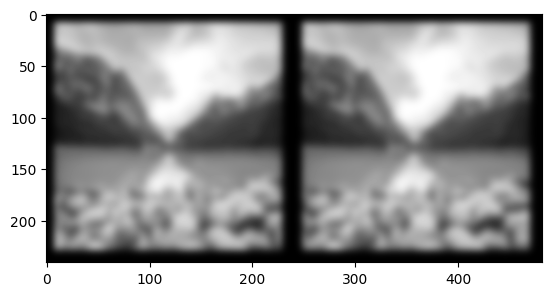

In [256]:
big_prosthetic = get_big_prosthesis()
big_percept_left = get_percept_data_from_image(img, scoreboard, big_prosthetic)
big_percept_right = get_percept_data_from_image(warped_image, scoreboard, big_prosthetic)

# idealized percepts still have the effect!
percept_side_by_side = np.hstack((big_percept_left, big_percept_right))
plt.imshow(percept_side_by_side, cmap='gray')

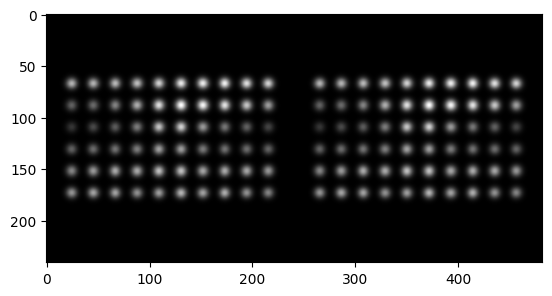

In [257]:
# now try argus II
argus = p2p.implants.ArgusII()
argus_percept_left = get_percept_data_from_image(img, scoreboard, argus)
argus_percept_right = get_percept_data_from_image(img, scoreboard, argus)

# resulting view is basically useless
percept_side_by_side = np.hstack((argus_percept_left, argus_percept_right))
plt.imshow(percept_side_by_side, cmap='gray')

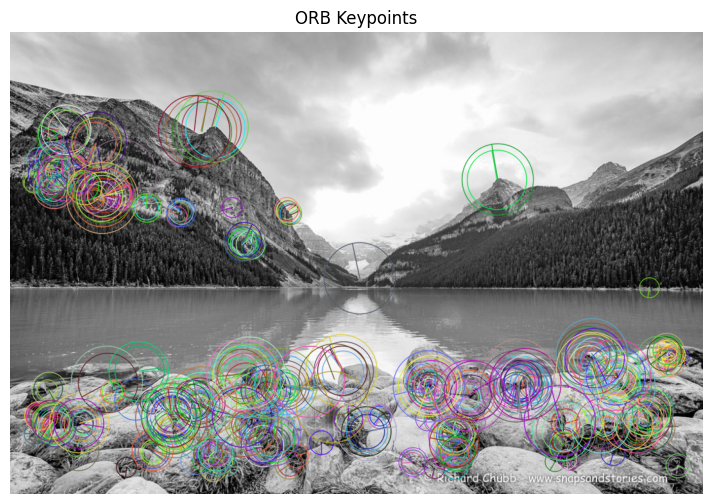

In [258]:
# OpenCV2 key point detection: 

# Load the image
image_path = "depth.jpg"  # Change to your image path
img_kp = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors
keypoints, descriptors = orb.detectAndCompute(img_kp, None)

# Draw keypoints on the image
img_keypoints = cv2.drawKeypoints(img_kp, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image with keypoints
plt.figure(figsize=(10, 6))
plt.imshow(img_keypoints, cmap='gray')
plt.title("ORB Keypoints")
plt.axis("off")
plt.show()

In [259]:
keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)

for keypoint in keypoints:
    print(keypoint.pt, keypoint.response)

(69.60000610351562, 616.800048828125) 0.0038904931861907244
(70.56000518798828, 616.3200073242188) 0.003807668574154377
(69.0, 618.0) 0.0034862197935581207
(652.0, 558.0) 0.0032359694596379995
(222.0, 654.0) 0.003174096578732133
(294.0, 579.0) 0.003105467651039362
(70.84800720214844, 616.8960571289062) 0.0030621669720858335
(328.0, 668.0) 0.002987281186506152
(255.0, 628.0) 0.0029844227246940136
(1024.0, 513.0) 0.0029661590233445168
(70.50241088867188, 613.7857055664062) 0.0029136089142411947
(294.0, 578.4000244140625) 0.00286081968806684
(693.0, 656.0) 0.002835240913555026
(641.0, 541.0) 0.002800676738843322
(946.0, 539.0) 0.002646259032189846
(926.0, 611.0) 0.0025712193455547094
(325.0, 679.0) 0.0025334390811622143
(255.60000610351562, 628.800048828125) 0.0023468753788620234
(430.0, 553.0) 0.0023049747105687857
(312.0, 682.0) 0.00229682051576674
(652.800048828125, 558.0) 0.002273408928886056
(294.0, 581.0) 0.0022051497362554073
(433.0, 278.0) 0.0022019147872924805
(222.00001525878906

In [260]:
keypoint_positions = [kp.pt for kp in keypoints][:100]
print(keypoint_positions)
keypoint_positions_shifted = [(j - x*eye_dist/(2*depth[int(i)][int(j)]*np.tan(fov_rad/2)), i) for (j, i) in keypoint_positions]

print(keypoint_positions_shifted)

[(69.60000610351562, 616.800048828125), (70.56000518798828, 616.3200073242188), (69.0, 618.0), (652.0, 558.0), (222.0, 654.0), (294.0, 579.0), (70.84800720214844, 616.8960571289062), (328.0, 668.0), (255.0, 628.0), (1024.0, 513.0), (70.50241088867188, 613.7857055664062), (294.0, 578.4000244140625), (693.0, 656.0), (641.0, 541.0), (946.0, 539.0), (926.0, 611.0), (325.0, 679.0), (255.60000610351562, 628.800048828125), (430.0, 553.0), (312.0, 682.0), (652.800048828125, 558.0), (294.0, 581.0), (433.0, 278.0), (222.00001525878906, 654.0), (945.6000366210938, 538.800048828125), (98.0, 209.0), (693.6000366210938, 654.0), (384.0, 628.0), (710.0, 653.0), (626.0, 670.0), (159.0, 561.0), (114.0, 609.0), (696.0, 656.0), (254.8800048828125, 627.8400268554688), (294.0, 580.800048828125), (978.0, 621.0), (37.0, 235.0), (813.0, 552.0), (105.0, 644.0), (309.0, 658.0), (714.0, 569.0), (681.0, 622.0), (1023.0, 510.0), (663.0, 605.0), (428.5440368652344, 552.9600830078125), (221.0, 576.0), (58.0, 557.0), 

(720, 1080, 3)


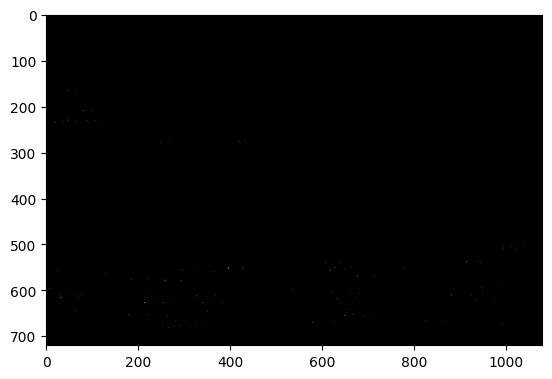

In [261]:
empty = np.zeros(img.shape)
print(img.shape)
for (j, i) in keypoint_positions:
    empty[int(i)][int(j)] = [1, 0, 0]
for (j, i) in keypoint_positions_shifted:
    empty[int(i)][int(j)] = [0, 1, 1]
plt.imshow(empty)

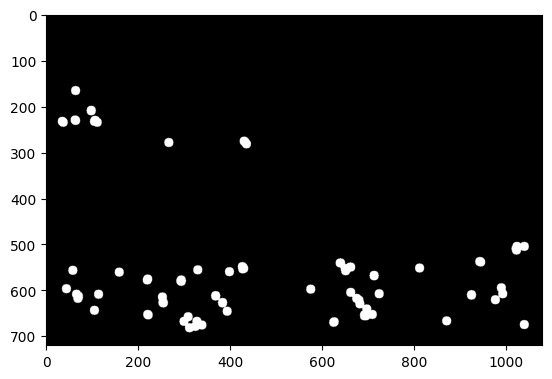

In [262]:
keypoints_left = np.zeros(img.shape)
for (j, i) in keypoint_positions:
    cv2.circle(keypoints_left, (int(j), int(i)), radius=10, color=(255, 255, 255), thickness=-1)
plt.imshow(keypoints_left)

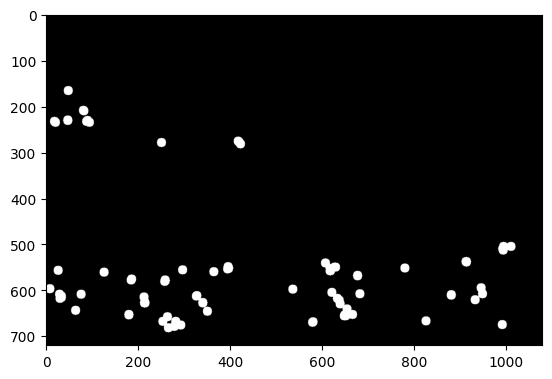

In [263]:
keypoints_right = np.zeros(img.shape)
for (j, i) in keypoint_positions_shifted:
    cv2.circle(keypoints_right, (int(j), int(i)), radius=10, color=(255, 255, 255), thickness=-1)
plt.imshow(keypoints_right)

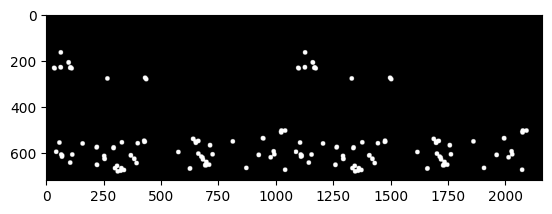

In [264]:
percept_side_by_side = np.hstack((keypoints_left, keypoints_right))
plt.imshow(percept_side_by_side, cmap='gray')

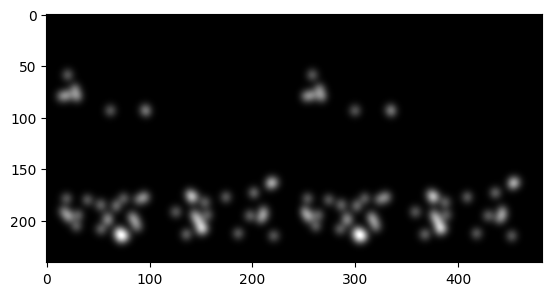

In [265]:
# map these key points onto electodes
# dumb way: use the image as a stimulus
# smart way: use the keypoints to trigger particular electrodes
# try both of these with big_prosthetic and argusII. 

# image stim big prosthetic - sort of works
keypoints_big_left = get_percept_data_from_image(keypoints_left, scoreboard, big_prosthetic)
keypoints_big_right = get_percept_data_from_image(keypoints_right, scoreboard, big_prosthetic)
percept_side_by_side = np.hstack((keypoints_big_left, keypoints_big_right))
plt.imshow(percept_side_by_side, cmap='gray')

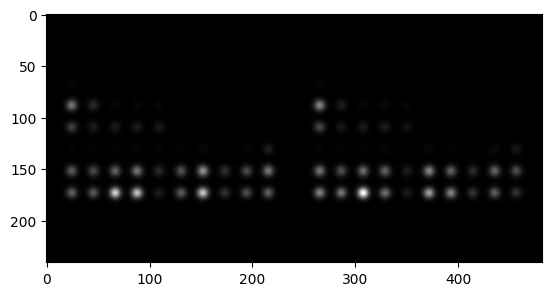

In [266]:
# image stim argus II - I don't think it really works
keypoints_argus_left = get_percept_data_from_image(keypoints_left, scoreboard, argus)
keypoints_argus_right = get_percept_data_from_image(keypoints_right, scoreboard, argus)
percept_side_by_side = np.hstack((keypoints_argus_left, keypoints_argus_right))
plt.imshow(percept_side_by_side, cmap='gray')

In [267]:
# direct electrode stim big prosthetic
print(big_prosthetic.electrodes)

OrderedDict([(0, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y=-3000, z=0)), (1, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y=-2900, z=0)), (2, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y=-2800, z=0)), (3, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y=-2700, z=0)), (4, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y=-2600, z=0)), (5, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y=-2500, z=0)), (6, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y=-2400, z=0)), (7, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y=-2300, z=0)), (8, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y=-2200, z=0)), (9, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y=-2100, z=0)), (10, DiskElectrode(activated=True, name=None, r=25, x=-3000, 
              y

In [268]:
print(scoreboard)

ScoreboardModel(engine=None, grid_type='rectangular', 
                n_gray=None, n_jobs=1, n_threads=4, 
                ndim=[2], noise=None, rho=100, 
                scheduler='threading', 
                spatial=ScoreboardSpatial, temporal=None, 
                thresh_percept=0, verbose=True, 
                vfmap=Watson2014Map(ndim=2), 
                xrange=(-12, 12), xystep=0.1, 
                yrange=(-12, 12))


<AxesSubplot: xlabel='x (microns)', ylabel='y (microns)'>

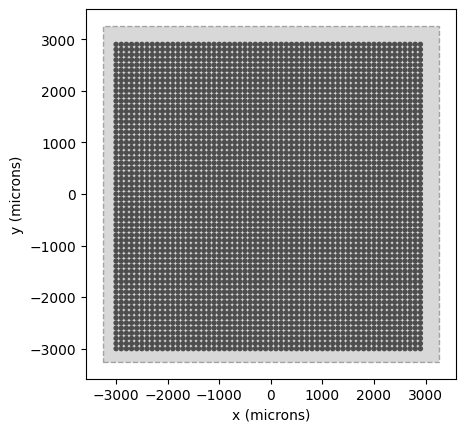

In [269]:
scoreboard.plot()
big_prosthetic.plot()

In [270]:
# we can normalize the electrode positions into the image dimensions. 
# then for each key point, find the closest normalized electrode. 
# then mark that electrode as illuminated
# then use that as the stim
def normalize(x, y, x_min, x_max, y_min, y_max, x_min_new, x_max_new, y_min_new, y_max_new):
    x_new = x_max_new - (x_max_new - x_min_new)/(x_max - x_min)*(x_max - x)
    y_new = y_max_new - (y_max_new - y_min_new)/(y_max - y_min)*(y_max - y)
    return (x_new, y_new)

def dist(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def get_stim_from_key_points(implant, keypoint_positions, img_shape):
    # this is how the Scoreboard model's plot gets its Cartesian size from xrange and yrange
    # i think the image is scaled to fit the topography map. 
    wm = p2p.topography.Watson2014Map()

    # normalize
    max_orig, min_orig = wm.dva_to_ret(12, 12) # numbers from xrange/yrange vals
    min_x_new = 0
    min_y_new = 0
    (max_y_new, max_x_new) = img_shape
    normalized_electrode_positions = []
    for name in implant.electrode_names:
        normalized_electrode_positions.append(normalize(
                                                implant.electrodes[name].x,
                                                implant.electrodes[name].y,
                                                min_orig, max_orig, 
                                                min_orig, max_orig, 
                                                min_x_new, max_x_new, 
                                                min_y_new, max_y_new))

    # go through keypoints to find the closest:
    nearest_electrodes = []
    for kpos in keypoint_positions:
        min_dist = 1e9
        min_electrode = -1
        for eind, epos in enumerate(normalized_electrode_positions):
            d = dist(kpos, epos)
            if d < min_dist:
                min_dist = d
                min_electrode = eind
        nearest_electrodes.append(min_electrode)

    # mark electrode as illuminated
    stim = [0] * implant.n_electrodes
    for electrode in nearest_electrodes:
        stim[electrode] = 1
    return stim

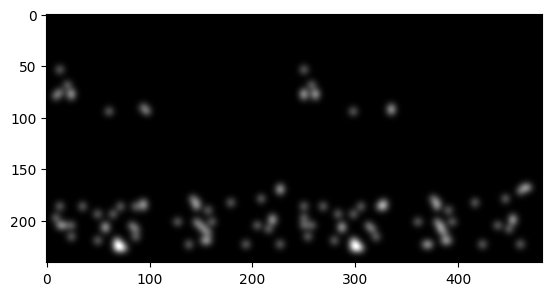

In [271]:
big_prosthetic.stim = get_stim_from_key_points(big_prosthetic, keypoint_positions, img.shape[0:2])
keypoints_smart_big_left = scoreboard.predict_percept(big_prosthetic).data
big_prosthetic.stim = get_stim_from_key_points(big_prosthetic, keypoint_positions_shifted, img.shape[0:2])
keypoints_smart_big_right = scoreboard.predict_percept(big_prosthetic).data
percept_side_by_side = np.hstack((keypoints_smart_big_left, keypoints_smart_big_right))
plt.imshow(percept_side_by_side, cmap='gray')


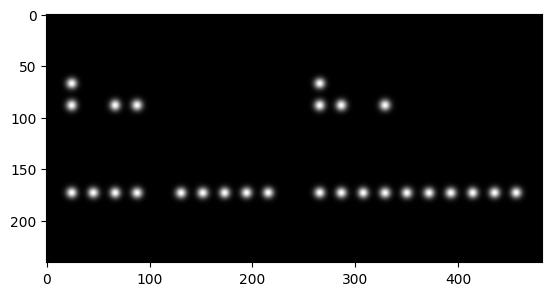

In [272]:
argus.stim = get_stim_from_key_points(argus, keypoint_positions, img.shape[0:2])
keypoints_smart_argus_left = scoreboard.predict_percept(argus).data
argus.stim = get_stim_from_key_points(argus, keypoint_positions_shifted, img.shape[0:2])
keypoints_smart_argus_right = scoreboard.predict_percept(argus).data
percept_side_by_side = np.hstack((keypoints_smart_argus_left, keypoints_smart_argus_right))
plt.imshow(percept_side_by_side, cmap='gray')